# 2.4.v1 - Modeling - content_based_model - TF-IDF based approach with n-grams and Entity Recognition

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import linear_kernel

from collections import Counter, OrderedDict
import re
import ast
import math
import requests, json

# Load library
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download the set of stop words the first time
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

%env GOOGLE_APPLICATION_CREDENTIALS=/Users/cesleemontgomery/masters/cs6460/CourseRec/courserec-adfe3-firebase-adminsdk-pm32q-6cd7a11195.json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


env: GOOGLE_APPLICATION_CREDENTIALS=/Users/cesleemontgomery/masters/cs6460/CourseRec/courserec-adfe3-firebase-adminsdk-pm32q-6cd7a11195.json


In [3]:
wiki_page_path_DF = pd.read_csv('../../data/processed/academic_outline_wikipedia_pages.csv')
course_subs_DF = pd.read_csv('../../data/processed/course_data_udacity.csv')

## 1 - Build Vocabulary = N-grams and Entity Recognition

1. Get N-grams
2. Filter through our wiki-based Entity Recognition Framework

### 1.1 - Get List of N-grams up to 4.

In [4]:
#1. get user model candidates
def get_ngrams(name, text, ngram_max=4):
    ngrams_vec = CountVectorizer(ngram_range=(1,ngram_max))
    analyzer = ngrams_vec.build_analyzer()
    ngrams = analyzer(text)
    print(name, ngrams[0:10])
    return ngrams

pre_process = lambda token: re.sub("[^a-zA-Z\s]+", "", token).lower() #simple pre-processing: remove punctuation and non-alpha, split whitespace, lowercase
stop_words = set(stopwords.words('english'))

flatten = lambda l: [pre_process(item) for sublist in l for item in sublist] 

ngrams_course = set(flatten(list(map(lambda course: get_ngrams(course.course_name, course.subtitles), course_subs_DF.itertuples())))).difference(stop_words)
ngrams_user = set(flatten(list(map(lambda user_interest: get_ngrams(user_interest.page_path_label, user_interest.page_text), wiki_page_path_DF[pd.notnull(wiki_page_path_DF.page_text)].itertuples())))).difference(stop_words)

Artificial Intelligence for Robotics ['proportional', 'tau', 'xy', 'pos', 'class', 'robot', 'setnoise', 'forwardnoiseturnnoise', 'sensenoise', 'posterior']
Intro to High-Performance Computing ['consider', 'this', 'network', 'have', 'bunch', 'of', 'questions', 'for', 'you', 'how']
Machine Learning ['gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt', 'gtgt']
Database Systems Concepts and Design ['sometimes', 'tables', 'are', 'already', 'indexed', 'by', 'the', 'database', 'management', 'system']
Knowledge-Based Artificial Intelligence: Cognitive Systems ['many', 'science', 'textbooks', 'in', 'middle', 'school', 'or', 'high', 'school', 'explain']
Educational Technology ['when', 'you', 'think', 'of', 'assessments', 'in', 'education', 'you', 'probably', 'think']
Introduction to Operating Systems ['to', 'make', 'things', 'concrete', 'lets', 'look', 'at', 'file', 'system', 'thats']
Computer Networks ['lets', 'have', 'another', 'quiz', 'on', 'data', 'centers', 'so', 'how', '

### 1.2 - Filter through wikipedia-based entity map

For time's sake a more efficient/quality way to check whether a word is an entity is to check it against Wikipedia titles.  This hack is likely to be a better bet because Wikipedia covers highly specific academic topics that might be hard to pull from existing named entity corpuses.

In [5]:
#1.2.1 get wiki NER corpus
wiki_titles = set(token.lower() for token in open("../../data/raw/articletitles_wikipedia/enwiki-latest-all-titles-in-ns0.txt", "r") \
                .read().splitlines())
len(wiki_titles)

def filter_wiki_entity_set(tokens):
    wiki_compatible_set = set(map(lambda token: token.replace(" ", "_"), tokens)) #must swap _ for space for article titles
    ngrams_search_patterns = wiki_compatible_set | set('{token}_(computing)'.format(token=token) for token in wiki_compatible_set) #add computing as these are also of interest, TODO - Can expand this further later
    ngrams_search_patterns_matches = set.intersection(ngrams_search_patterns, wiki_titles)
    return ngrams_search_patterns_matches

def is_not_type_disambiguation_page(title):
    url = """https://en.wikipedia.org/api/rest_v1/page/summary/{title}""".format(title=title)

    response = requests.get(url)
    if response.status_code == 200:
        data = json.loads(response.text)
        if data['type'] != 'disambiguation':
            return True
        else:
            return False
    else:
        return False

# #TODO

In [6]:
#1.2.2 filter tokens through wiki-based entity map to get entities
entities_course = filter_wiki_entity_set(ngrams_course)
entities_user = filter_wiki_entity_set(ngrams_user)
# entities_course = set( \
#                         filter(None, map(lambda title: title.replace("_(computing)", "").replace("_", " ") \    #remove wiki-compatible labels
#                                             if is_not_type_disambiguation_page(title), \                        #remove disambiguation pages
#                             filter_wiki_entity_set(ngrams_course)))                                             #after having filtered through wiki-based entity map
                      
# entities_user = filter_wiki_entity_set(ngrams_user)

Let's see how we did by filtering out ngrams given identification as a wikipedia-based entity...

In [7]:
len(entities_course)

53251

In [8]:
list(entities_course)[0:100]

['feathered',
 'jumble',
 'just_like_real_life',
 'pesky',
 'connected',
 'linear_mapping',
 'most_of_all',
 'principales',
 'zasad',
 'muda',
 'search',
 'the_counts',
 'in_action',
 'transformation_problem',
 'taste_it',
 'better_than_most',
 'apply_pressure',
 'virii',
 'aus',
 'uml_modeling',
 'the_shock',
 'laptop_computer',
 'person',
 'caminho',
 'pink_line',
 'two_children',
 'polarity',
 'soar',
 'some_dude',
 'security_level',
 'inny',
 'absolute_consistency',
 'special_features',
 'kuna',
 'string_copy',
 'the_exposures',
 'threat_model',
 'grauman',
 'distributed_version_control_system',
 'the_woods',
 'nonblocking',
 'pancakes',
 'concept_class',
 'programmed',
 'entity_integrity',
 'communications',
 'sub_compacts',
 'suerte',
 'carmichael_numbers',
 'oda',
 'panjang',
 'retinas',
 'box_blur',
 'caters',
 'cyclic',
 'moi',
 'scientific_inquiry',
 'pick_six',
 'formal_logic',
 'you_stay',
 'picnic',
 'ridge',
 'call_return',
 'the_seer',
 'the_unix_system',
 'think_about_i

I feel pretty good about this!! Removes a lot of words that users might consider random if they showed up alongside recommendations.  Again this is important in order to gain their confidence in the system's recommendations.

Let's move on.

## 2 - TF-IDF of Models w/wiki-based entities

### 0. Get Vocabulary + Last pre-processing step = lemmatize

In [9]:
vocabulary = entities_user | entities_course

lemma = nltk.wordnet.WordNetLemmatizer()
vocabulary = set(map(lemma.lemmatize, list(vocabulary)))

documents_user = list(map(lambda token: lemma.lemmatize(token), wiki_page_path_DF.page_text.astype('U')))
documents_course = list(map(lambda token: lemma.lemmatize(token), course_subs_DF.subtitles.astype('U')))

### 2.1 User Model TF-IDF

In [10]:
documents_labels_user = wiki_page_path_DF.page_path_label

#1. use vocabulary entities_user to get counts for all user model documents (academic interests)
vectorizer_user = CountVectorizer(vocabulary=list(vocabulary), ngram_range=(1,4))
entities_counts_user = vectorizer_user.fit_transform(documents_user)
#2. get TF-IDF weights
transformer_user = TfidfTransformer()
tfidf_matrix_user = transformer_user.fit_transform(entities_counts_user)
tfidif_df_user = pd.DataFrame(tfidf_matrix_user.toarray(), index=documents_labels_user, columns = vectorizer_user.get_feature_names())
tfidif_df_user.head()

,,panasonic,just_like_real_life,negative_energy,vanderbei,clarke,anticipatory_breach,principales,massive_star,the_fanatical,...,yucca_moth,mary_louise,entropy_production,antigo,the_newspaper,king_wenceslas,mag,new_england_healthcare_institute,international_communist_movement,loin_cloth
page_path_label,,,,,,,,,,,,,,,,,,,,,
Humanities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts > Music,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts > Music > Accompanying,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Course Model TF-IDF

In [11]:
documents_labels_course = course_subs_DF.course_name

#1. use vocabulary entities_course to get counts for all course model documents (subtitles)
vectorizer_course = CountVectorizer(vocabulary=list(vocabulary), ngram_range=(1,4))
entities_counts_course = vectorizer_course.fit_transform(documents_course)
#2. get TF-IDF weights
transformer_course = TfidfTransformer()
tfidf_matrix_course = transformer_course.fit_transform(entities_counts_course)
tfidif_df_course = pd.DataFrame(tfidf_matrix_course.toarray(), index=documents_labels_course, columns = vectorizer_course.get_feature_names())
tfidif_df_course.head()

,,panasonic,just_like_real_life,negative_energy,vanderbei,clarke,anticipatory_breach,principales,massive_star,the_fanatical,...,yucca_moth,mary_louise,entropy_production,antigo,the_newspaper,king_wenceslas,mag,new_england_healthcare_institute,international_communist_movement,loin_cloth
course_name,,,,,,,,,,,,,,,,,,,,,
Artificial Intelligence for Robotics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000299,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Intro to High-Performance Computing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Machine Learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000585,0.0,0.0,0.0,0.0,0.0,0.0
Database Systems Concepts and Design,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Knowledge-Based Artificial Intelligence: Cognitive Systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Computer Cosine Similarity Matrix

In [12]:
cosine_similarities_matrix = linear_kernel(tfidf_matrix_course, tfidf_matrix_user, dense_output=True).T
cosine_similarities_df = pd.DataFrame(cosine_similarities_matrix, index=documents_labels_user, columns = documents_labels_course)

In [13]:
np.shape(cosine_similarities_matrix)

(985, 28)

In [14]:
cosine_similarities_df.head()

course_name,Artificial Intelligence for Robotics,Intro to High-Performance Computing,Machine Learning,Database Systems Concepts and Design,Knowledge-Based Artificial Intelligence: Cognitive Systems,Educational Technology,Introduction to Operating Systems,Computer Networks,Special Topics: Big Data for Health Informatics,Advanced Operating Systems,...,Introduction to Information Security,Embedded Systems Optimization,Computational Photography,Machine Learning for Trading,Reinforcement Learning,Human-Computer Interaction,Software Development Process,Intro to Cyber Physical Systems Security,Intro to Graduate Algorithms,Software Architecture and Design
page_path_label,,,,,,,,,,,,,,,,,,,,,
Humanities,0.122886,0.430935,0.151800,0.408447,0.476527,0.444519,0.431547,0.454608,0.376314,0.438152,...,0.389861,0.430633,0.381299,0.399932,0.301107,0.489384,0.431053,0.436730,0.342149,0.497027
Humanities > Arts,0.083332,0.290128,0.103179,0.282648,0.316771,0.286860,0.308138,0.320676,0.255699,0.307125,...,0.283560,0.298897,0.267493,0.260530,0.200498,0.346339,0.302805,0.324625,0.227127,0.361017
Humanities > Arts > Performing arts,0.088451,0.255827,0.097983,0.251859,0.269632,0.247554,0.262352,0.267966,0.217726,0.268269,...,0.222316,0.265384,0.232625,0.237238,0.181002,0.276129,0.260635,0.244928,0.216769,0.294685
Humanities > Arts > Performing arts > Music,0.049343,0.171059,0.062010,0.175625,0.181494,0.168644,0.174152,0.178817,0.149307,0.171215,...,0.161695,0.168984,0.148857,0.154863,0.117184,0.196772,0.167287,0.176893,0.134158,0.200089
Humanities > Arts > Performing arts > Music > Accompanying,0.041960,0.161576,0.055833,0.150599,0.170753,0.160284,0.167930,0.168654,0.140667,0.159252,...,0.168942,0.154069,0.143075,0.147970,0.111915,0.180002,0.161271,0.171821,0.128192,0.189566


## 4. Evaluation - Ad Hoc

In [15]:
def get_course_recs(interest_label, interest_idx, course_labels, model=cosine_similarities_matrix, top_n=8):
    related_docs_indices = model[interest_idx].argsort()[:-top_n:-1]
    scores = model[interest_idx][related_docs_indices]
    print('Course Recs for {interest}:'.format(interest=interest_label))
    display(pd.Series(scores, index=course_labels[related_docs_indices]))

Trying a few interests to get recommendations to eyeball:

In [16]:
print(cosine_similarities_df.index.values)

['Humanities' 'Humanities > Arts' 'Humanities > Arts > Performing arts'
 'Humanities > Arts > Performing arts > Music'
 'Humanities > Arts > Performing arts > Music > Accompanying'
 'Humanities > Arts > Performing arts > Music > Chamber music'
 'Humanities > Arts > Performing arts > Music > Church music'
 'Humanities > Arts > Performing arts > Music > Conducting'
 'Humanities > Arts > Performing arts > Music > Early music'
 'Humanities > Arts > Performing arts > Music > Jazz studies'
 'Humanities > Arts > Performing arts > Music > Musical composition'
 'Humanities > Arts > Performing arts > Music > Music education'
 'Humanities > Arts > Performing arts > Music > Music history'
 'Humanities > Arts > Performing arts > Music > Musicology'
 'Humanities > Arts > Performing arts > Music > Ethnomusicology'
 'Humanities > Arts > Performing arts > Music > Music theory'
 'Humanities > Arts > Performing arts > Music > Orchestral studies'
 'Humanities > Arts > Performing arts > Music > Organology'

In [17]:
interest_label = 'Applied Sciences > Business'
interest_idx = wiki_page_path_DF[wiki_page_path_DF.page_path_label == interest_label].index.item()
course_labels = course_subs_DF['course_name']

get_course_recs(interest_label, interest_idx, course_labels=course_labels, model=cosine_similarities_matrix, top_n=20)

Course Recs for Applied Sciences > Business:


course_name
Intro to Cyber Physical Systems Security                      0.338782
Software Architecture and Design                              0.327614
Machine Learning for Trading                                  0.310474
Human-Computer Interaction                                    0.306831
Introduction to Information Security                          0.305286
Introduction to Operating Systems                             0.305123
Computer Networks                                             0.286937
Advanced Operating Systems                                    0.286099
Knowledge-Based Artificial Intelligence: Cognitive Systems    0.283121
Embedded Systems Optimization                                 0.280626
Educational Technology                                        0.278704
Software Analysis                                             0.278550
Software Development Process                                  0.276557
Intro to Health Informatics                                   0.2

## 5 Offline Evaluation (via manually generated scenarios)

This is the closest we'll come to evaluation since we don't have historical user data.  Let's compare manually to other sane baselines.

In [18]:
course_key = {
    #Hand-picked as more related to social/humanities disciplines
    'Human-Computer Interaction': 'red',
    'Intro to Health Informatics': 'red',
    'Educational Technology': 'red',

    #Hand-picked as more related to engineering/systems disciplines
    'Database Systems Concepts and Design': 'green',
    'Computer Networks': 'green',
    'Compilers - Theory and Practice': 'green',

    #Hand-picked as more related to math/highly quantitative disciplines
    'Machine Learning': 'blue',
    'Reinforcement Learning': 'blue',
    'Data and Visual Analytics': 'blue'
}

def color_hand_classified_courses(course, key=course_key):
    """
    Takes a course (string) and colors specific courses 
    according to a hand-created classification key, designed
    to compare broad sub-categories of Computer Science 
    across academic interests.
    """
    if course in key.keys():
        color = key[course]
    else: color = 'gainsboro'
    return 'background-color: %s' % color

In [19]:
#1. write Rank x Categories (values=Course)
def build_comparison_DF(df): 
    work_df_ranked = pd.DataFrame(index=pd.Index(range(1,29), name='rank'))
    work_df = df
    for interest in work_df:
        tempdf = work_df[interest].rank(ascending=False).astype('int').rename('rank').reset_index().set_index('rank')
    #     print(work_df[interest].rank(ascending=False).sort_values())
    #     break
        tempdf.columns = [interest]
        work_df_ranked = work_df_ranked.join(tempdf)
    return work_df_ranked

#### 5.1 Categories Scenarios (w/Explanations) (Comparison to Random or TF-IDF)

In [20]:
#1. write Rank x Categories (values=Course) ; get categories (will serve as spectrum from social to mathy/engr-y [])
categories_DF = pd.DataFrame(cosine_similarities_df.T.loc[:,wiki_page_path_DF.category_h2_1.unique()])

#2. Declare course key, scan table for course key and color with course.color
(build_comparison_DF(categories_DF).style
  .applymap(color_hand_classified_courses)
  .set_caption('Course Rank by Academic Discipline'))

,Humanities,Social sciences,Natural Sciences,Formal Sciences,Applied Sciences
rank,,,,,
1,Software Architecture and Design,Human-Computer Interaction,Software Architecture and Design,Software Analysis,Intro to Health Informatics
2,Human-Computer Interaction,Software Architecture and Design,Human-Computer Interaction,Software Architecture and Design,Intro to Cyber Physical Systems Security
3,Software Analysis,Software Analysis,Software Analysis,Human-Computer Interaction,Human-Computer Interaction
4,Knowledge-Based Artificial Intelligence: Cognitive Systems,Knowledge-Based Artificial Intelligence: Cognitive Systems,Knowledge-Based Artificial Intelligence: Cognitive Systems,Intro to Cyber Physical Systems Security,Software Architecture and Design
5,Computer Networks,Intro to Cyber Physical Systems Security,Intro to Cyber Physical Systems Security,Advanced Operating Systems,Software Development Process
6,Educational Technology,Educational Technology,Advanced Operating Systems,Introduction to Operating Systems,Knowledge-Based Artificial Intelligence: Cognitive Systems
7,Advanced Operating Systems,Computer Networks,Computer Networks,Software Development Process,Educational Technology
8,Intro to Cyber Physical Systems Security,Advanced Operating Systems,Introduction to Operating Systems,Knowledge-Based Artificial Intelligence: Cognitive Systems,Introduction to Operating Systems
9,Introduction to Operating Systems,Introduction to Operating Systems,Software Development Process,Computer Networks,Software Analysis


#### 5.2 Computer Science vs Computer Science classes

In [21]:
computer_science_interests_courses_keys = { 
    'Formal Sciences > Computer Science > Logic in computer science':{},
       'Formal Sciences > Computer Science > Algorithms':{'strong':['Intro to Graduate Algorithms']},
       'Formal Sciences > Computer Science > Artificial intelligence':{'strong':['Artificial Intelligence', 'Artificial Intelligence for Robotics', 'Machine Learning', 'Knowledge-Based Artificial Intelligence: Cognitive Systems', 'Computer Vision', 'Reinforcement Learning'], 'weak':['Computational Photography', 'Machine Learning for Trading']},
       'Formal Sciences > Computer Science > Data structures':{'weak':['Database Systems Concepts and Design', 'Data and Visual Analytics']},
       'Formal Sciences > Computer Science > Computer architecture':{'strong':['High Performance Computer Architecture', 'Intro to High-Performance Computing'], 'weak':['Software Architecture and Design']},
       'Formal Sciences > Computer Science > Computer graphics':{'weak':['Intro to High-Performance Computing', 'High Performance Computer Architecture']},
       'Formal Sciences > Computer Science > Computer communications (networks)':{'strong':['Computer Networks', 'Network Security']},
       'Formal Sciences > Computer Science > Computer security and reliability':{'strong':['Network Security', 'Introduction to Information Security', 'Intro to Cyber Physical Systems Security']},
       'Formal Sciences > Computer Science > Computing in mathematics, natural sciences, engineering, and medicine':{'strong':['Intro to Health Informatics', 'Special Topics: Big Data for Health Informatics'], 'weak':['Data and Visual Analytics', 'Machine Learning', 'Computational Photography']},
       'Formal Sciences > Computer Science > Computing in social sciences, arts, humanities, and professions':{'weak':['Data and Visual Analytics', 'Educational Technology', 'Machine Learning for Trading']},
       'Formal Sciences > Computer Science > Distributed computing':{'strong':['Intro to High-Performance Computing', 'High Performance Computer Architecture']},
       'Formal Sciences > Computer Science > Human-computer interaction':{'strong':['Human-Computer Interaction']},
       'Formal Sciences > Computer Science > Operating systems':{'strong':['Introduction to Operating Systems', 'Advanced Operating Systems', 'Embedded Systems Optimization']},
       'Formal Sciences > Computer Science > Parallel computing':{'strong':['Intro to High-Performance Computing', 'High Performance Computer Architecture']},
       'Formal Sciences > Computer Science > Programming languages':{'weak':['Compilers - Theory and Practice']},
       'Formal Sciences > Computer Science > Quantum computing':{'weak':['Intro to High-Performance Computing', 'High Performance Computer Architecture']},
       'Formal Sciences > Computer Science > Software engineering':{'strong':['Database Systems Concepts and Design', 'Software Analysis', 'Software Development Process', 'Software Architecture and Design']},
       'Formal Sciences > Computer Science > Theory of computation':{'strong':['Intro to Graduate Algorithms']},
       'Formal Sciences > Computer Science > VLSI design':{}
}

def color_course_match(course, name, key):
    
    color = 'gainsboro' #default color
    if name in key:
        category_labels = key[name]
        if category_labels:
            for label, courses in category_labels.items():
                if course in courses:
                    color = 'blue' if label == 'strong' else 'orange'
    return 'background-color: %s' % color

def color_hand_classified_CS_course(series, course_key=computer_science_interests_courses_keys):
    """
    Takes a course and colors specific courses 
    according to a hand-created classification key, designed
    to compare broad sub-categories of Computer Science 
    across academic interests.
    """
    return series.apply(lambda course: color_course_match(course, series.name, course_key))


In [22]:
# #1. write Rank x Categories (values=Course) ; get computer science courses
tempdf = (wiki_page_path_DF.loc[(wiki_page_path_DF['sub_category_h3_2'] == 'Computer Science') 
                                    & (pd.notnull(wiki_page_path_DF['topic_3']))
                                    & (pd.isnull(wiki_page_path_DF['subtopic_4']))
                                    & (pd.isnull(wiki_page_path_DF['subtopic_5'])), ['page_path_label', 'sub_category_h3_2']])
tempdf = cosine_similarities_df.join(tempdf.set_index('page_path_label'), how='inner')

temp_df = (build_comparison_DF(tempdf.iloc[:, :-1].transpose()).style
  .apply(color_hand_classified_CS_course, axis=0))

html = temp_df.render()
from IPython.display import display, HTML
display( HTML( html ) )
# import imgkit
# imgkit.from_string(html, 'v1Offline evaluationCS.png')

,Formal Sciences > Computer Science > Logic in computer science,Formal Sciences > Computer Science > Algorithms,Formal Sciences > Computer Science > Artificial intelligence,Formal Sciences > Computer Science > Data structures,Formal Sciences > Computer Science > Computer architecture,Formal Sciences > Computer Science > Computer graphics,Formal Sciences > Computer Science > Computer communications (networks),Formal Sciences > Computer Science > Computer security and reliability,"Formal Sciences > Computer Science > Computing in mathematics, natural sciences, engineering, and medicine","Formal Sciences > Computer Science > Computing in social sciences, arts, humanities, and professions",Formal Sciences > Computer Science > Distributed computing,Formal Sciences > Computer Science > Human-computer interaction,Formal Sciences > Computer Science > Operating systems,Formal Sciences > Computer Science > Parallel computing,Formal Sciences > Computer Science > Programming languages,Formal Sciences > Computer Science > Quantum computing,Formal Sciences > Computer Science > Software engineering,Formal Sciences > Computer Science > Theory of computation,Formal Sciences > Computer Science > VLSI design
rank,,,,,,,,,,,,,,,,,,,
1,Knowledge-Based Artificial Intelligence: Cognitive Systems,Intro to High-Performance Computing,Knowledge-Based Artificial Intelligence: Cognitive Systems,Special Topics: Big Data for Health Informatics,Advanced Operating Systems,Human-Computer Interaction,Computer Networks,Intro to Cyber Physical Systems Security,Intro to Health Informatics,Software Architecture and Design,Advanced Operating Systems,Human-Computer Interaction,Advanced Operating Systems,Introduction to Operating Systems,Software Analysis,Intro to High-Performance Computing,Software Development Process,Software Architecture and Design,Human-Computer Interaction
2,Software Architecture and Design,Software Analysis,Human-Computer Interaction,Data and Visual Analytics,Introduction to Operating Systems,Computational Photography,Intro to Cyber Physical Systems Security,Introduction to Information Security,Software Architecture and Design,Human-Computer Interaction,Intro to High-Performance Computing,Database Systems Concepts and Design,Introduction to Operating Systems,Advanced Operating Systems,Software Architecture and Design,Software Architecture and Design,Software Architecture and Design,Intro to High-Performance Computing,Software Architecture and Design
3,Software Analysis,Intro to Graduate Algorithms,Software Architecture and Design,Advanced Operating Systems,Human-Computer Interaction,Software Architecture and Design,Network Security,Network Security,Human-Computer Interaction,Software Analysis,Introduction to Operating Systems,Software Architecture and Design,Introduction to Information Security,High Performance Computer Architecture,Introduction to Operating Systems,Software Analysis,Software Analysis,Knowledge-Based Artificial Intelligence: Cognitive Systems,Intro to Cyber Physical Systems Security
4,Intro to Cyber Physical Systems Security,Software Architecture and Design,Educational Technology,Intro to Health Informatics,Software Architecture and Design,Software Analysis,Introduction to Information Security,Computer Networks,Software Analysis,Knowledge-Based Artificial Intelligence: Cognitive Systems,Intro to Cyber Physical Systems Security,Introduction to Operating Systems,Intro to Cyber Physical Systems Security,Intro to High-Performance Computing,Advanced Operating Systems,Advanced Operating Systems,Human-Computer Interaction,Software Analysis,Computer Networks
5,Software Development Process,Knowledge-Based Artificial Intelligence: Cognitive Systems,Software Analysis,Machine Learning for Trading,High Performance Computer Architecture,Advanced Operating Systems,Advanced Operating Systems,Software Architecture and Design,Knowledge-Based Artificial Intelligence: Cognitive Systems,Intro to Cyber Physical Systems Security,Computer Networks,Intr

Looks phenomenal! New color key shows the difference between weaker vs stronger signals. The only one worth digging into further is AI.

These results are without cleaning of disambiguated entities.


## 6. Summary

- TODO for v2
    - Worth trying to clean up disambiguated entities and possibly some POS tagging and removal of categories not in (NN, NNP, NNS, JJS).

## 7. Productionize Recommendations - Write to Firebase

### 7.1 Recommendations, Scores

In [23]:
NB_model_recommendations_DF = cosine_similarities_df.T

UI_interests = OrderedDict({
    'Computer Science': {'Formal Sciences':['Computer Science']},
    'Math & Statistics': {'Formal Sciences':['Mathematics', 'Statistics']},
    'Engineering & Tech': {'Applied Sciences':['Engineering and technology']}, 
    'Business': 'Business',
    'Medicine & Health': {'Applied Sciences':['Medicine and health']},
    'Natural Sciences': 'Natural Sciences',
    'Social Sciences': 'Social sciences',
    'Humanities': 'Humanities'
})

worklist = []
# for i, (key, value) in enumerate(d.items())
for i, (interest_label, interest_id) in enumerate(UI_interests.items()):
    if isinstance(interest_id, dict):
        category_id = list(interest_id.values())[0]
        tempdf = pd.DataFrame(wiki_page_path_DF.loc[(wiki_page_path_DF.sub_category_h3_2.isin(list(interest_id.values())[0])), 'page_path_label'])
        course_recommendations = pd.merge(tempdf, NB_model_recommendations_DF.transpose(), left_on='page_path_label', right_index=True).drop(columns=['page_path_label']).mean().to_dict()
    elif interest_label == 'Business':
        category_id = [interest_id]
        tempdf = pd.DataFrame(wiki_page_path_DF.loc[(wiki_page_path_DF.sub_category_h3_2 == interest_id), 'page_path_label'])
        course_recommendations = pd.merge(tempdf, NB_model_recommendations_DF.transpose(), left_on='page_path_label', right_index=True).drop(columns=['page_path_label']).to_dict('records')[0]
    else:
        category_id = [interest_id]
        course_recommendations = NB_model_recommendations_DF.transpose().loc[category_id[0]].to_dict()
    #categoryLabel, categoryIDs, course_recommendations:{category:prediction}
    worklist.append([interest_label, category_id, course_recommendations])
    
workdf = pd.DataFrame(worklist, columns=['interest_label', 'category_id', 'course_recommendations'])
workdf

,interest_label,category_id,course_recommendations
0,Computer Science,[Computer Science],{'Artificial Intelligence for Robotics': 0.059...
1,Math & Statistics,"[Mathematics, Statistics]",{'Artificial Intelligence for Robotics': 0.059...
2,Engineering & Tech,[Engineering and technology],{'Artificial Intelligence for Robotics': 0.044...
3,Business,[Business],{'Artificial Intelligence for Robotics': 0.070...
4,Medicine & Health,[Medicine and health],{'Artificial Intelligence for Robotics': 0.047...
5,Natural Sciences,[Natural Sciences],{'Artificial Intelligence for Robotics': 0.087...
6,Social Sciences,[Social sciences],{'Artificial Intelligence for Robotics': 0.078...
7,Humanities,[Humanities],{'Artificial Intelligence for Robotics': 0.122...


In [24]:
# # Some help from: https://medium.com/@hmurari/cloud-firestore-batch-transactions-how-to-migrate-a-large-amounts-of-data-336e61efbe7c
# # Use the application default credentials
# cred = credentials.ApplicationDefault()
# firebase_admin.initialize_app(cred, {
#   'projectId': 'courserec-adfe3',
# })

# db = firestore.client()

In [25]:
# recommendations_collection = db.collection(u'recommendations')

# #for batching
# total = len(workdf)
# counter = 0

# # Start a batch
# batch = db.batch()
# for idx, record in workdf.iterrows():
#     # Commit the batch at every 500th record.
#     if counter % 500 == 0:
#         if counter > 0:
#             print('Committing..')
#             batch.commit()

#         # Start a new batch for the next iteration.
#         batch = db.batch()
#     counter += 1
#     print(str(counter) + str('/') + str(total) + ': ' + str(record.interest_label))
#     record_id = record.interest_label
#     record_ref = recommendations_collection.document(str(record_id))
#     # Include current record in batch
#     batch.set(record_ref, 
#         {
#             "categoryLabel": record.interest_label,
#             "courseRecommendations": record.course_recommendations
#     })

# # Include current record in batch
# if counter % 500 != 0:
#     print('Committing..')
#     batch.commit()

### 7.2 TODO Tags

Ideally we can clean these up so that we can expose the user model to the student for them to refine.

In [26]:
tfidif_df_course.head()

,,panasonic,just_like_real_life,negative_energy,vanderbei,clarke,anticipatory_breach,principales,massive_star,the_fanatical,...,yucca_moth,mary_louise,entropy_production,antigo,the_newspaper,king_wenceslas,mag,new_england_healthcare_institute,international_communist_movement,loin_cloth
course_name,,,,,,,,,,,,,,,,,,,,,
Artificial Intelligence for Robotics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000299,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Intro to High-Performance Computing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Machine Learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000585,0.0,0.0,0.0,0.0,0.0,0.0
Database Systems Concepts and Design,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Knowledge-Based Artificial Intelligence: Cognitive Systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
tfidif_df_user.head()

,,panasonic,just_like_real_life,negative_energy,vanderbei,clarke,anticipatory_breach,principales,massive_star,the_fanatical,...,yucca_moth,mary_louise,entropy_production,antigo,the_newspaper,king_wenceslas,mag,new_england_healthcare_institute,international_communist_movement,loin_cloth
page_path_label,,,,,,,,,,,,,,,,,,,,,
Humanities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts > Music,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities > Arts > Performing arts > Music > Accompanying,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
tempseriesA = tfidif_df_course.loc['Artificial Intelligence']
tempseriesA = tempseriesA[tempseriesA != 0].sort_values(ascending=False)

tempseriesB = tfidif_df_user.loc['Formal Sciences > Computer Science > Artificial intelligence'] 
tempseriesB = tempseriesB[tempseriesB != 0]

In [55]:
(tempseriesA.to_frame()).join(tempseriesB.to_frame(), how='inner')

,Artificial Intelligence,Formal Sciences > Computer Science > Artificial intelligence
in,0.160332,0.217841
de,0.146765,0.001188
der,0.127207,0.001908
do,0.072663,0.017941
at,0.071478,0.039262
so,0.070688,0.010755
bayes,0.069976,0.007800
von,0.063670,0.003211
can,0.053786,0.070061
are,0.046994,0.069746


Tags need quite a bit of cleaning to be able to present to the user.

TODO - Disambiguation or other NER would be necessary to remove non-conceptual words that are likely to sow distrust with the user.

### 7.3 - Thresholding -  Where to limit recommendations?

(1, 0)

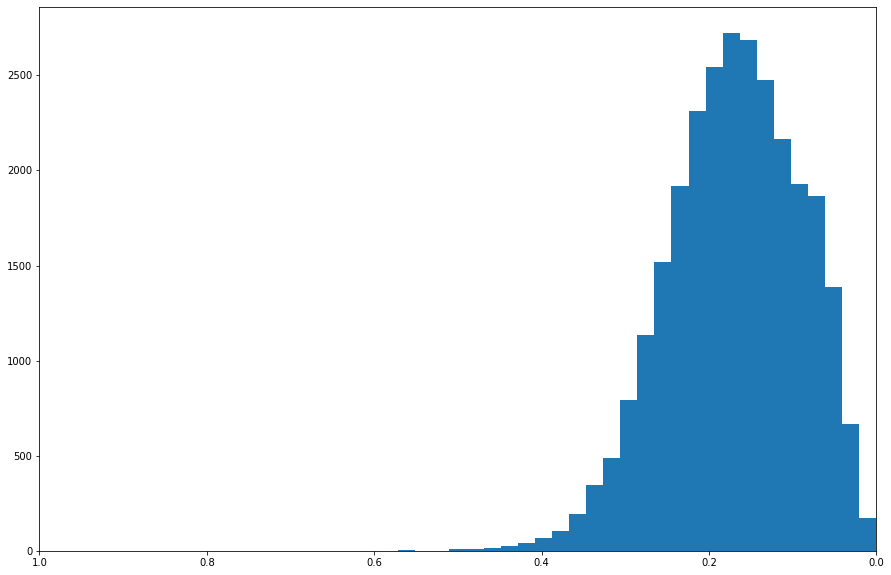

In [91]:
fig, ax = pyplot.subplots(1, 1, figsize=(15, 10))

bins = numpy.linspace(0, 1, 50)
pyplot.hist(cosine_similarities_matrix.flatten(), bins)
pyplot.xlim([1, 0])

(1, 0)

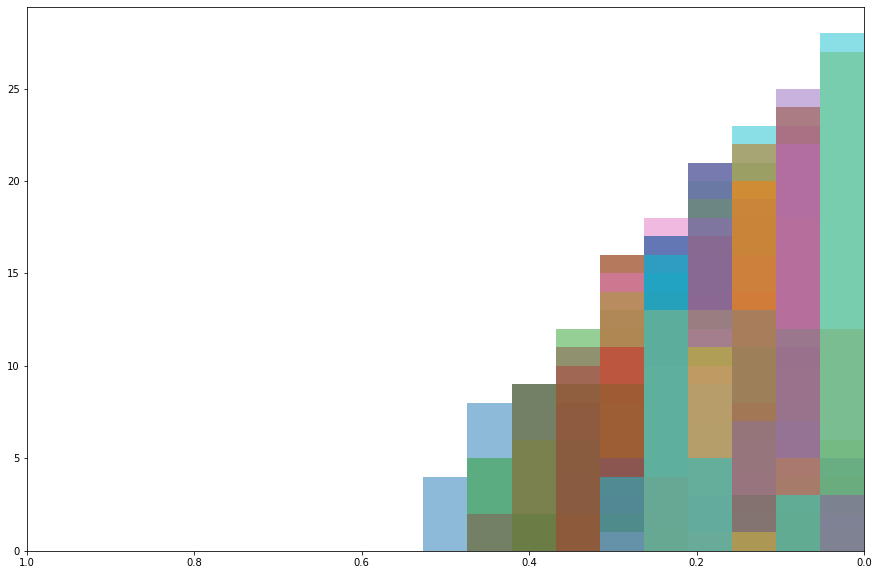

In [82]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0, 1, 20)

fig, ax = pyplot.subplots(1, 1, figsize=(15, 10))

for idx, interest in cosine_similarities_df.head(100).iterrows():
#     print(idx, interest)
    ax = pyplot.hist(interest, bins, alpha=0.5, label=interest.name);
pyplot.xlim([1, 0])
# pyplot.legend(loc='upper right');
#pyplot.figure(figsize=(18,6))